In [52]:
!echo %cd%

c:\Users\admin\Desktop\0702


In [53]:
import torch
# CUDA 사용 가능 여부 확인
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


---
오브젝트 여러개 보여주는 코드

Type of targets: <class 'list'>
Content of targets: [{'xmin': tensor([54]), 'ymin': tensor([31]), 'xmax': tensor([160]), 'ymax': tensor([143]), 'label': ['red apple']}, {'xmin': tensor([180]), 'ymin': tensor([48]), 'xmax': tensor([284]), 'ymax': tensor([146]), 'label': ['red apple']}, {'xmin': tensor([301]), 'ymin': tensor([52]), 'xmax': tensor([392]), 'ymax': tensor([146]), 'label': ['red apple']}, {'xmin': tensor([408]), 'ymin': tensor([42]), 'xmax': tensor([505]), 'ymax': tensor([148]), 'label': ['red apple']}, {'xmin': tensor([30]), 'ymin': tensor([179]), 'xmax': tensor([133]), 'ymax': tensor([289]), 'label': ['green apple']}, {'xmin': tensor([148]), 'ymin': tensor([172]), 'xmax': tensor([260]), 'ymax': tensor([295]), 'label': ['red apple']}, {'xmin': tensor([280]), 'ymin': tensor([179]), 'xmax': tensor([390]), 'ymax': tensor([291]), 'label': ['green apple']}, {'xmin': tensor([406]), 'ymin': tensor([169]), 'xmax': tensor([519]), 'ymax': tensor([292]), 'label': ['red apple']}, {'xmi

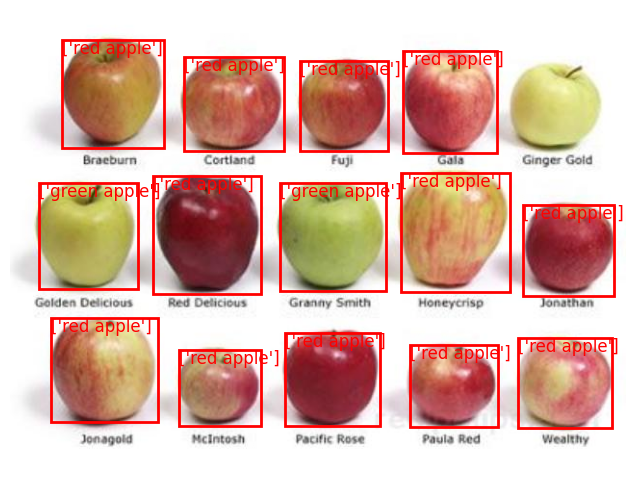

In [54]:
import os
import xml.etree.ElementTree as ET
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import matplotlib.patches as patches

class myDataSet(torch.utils.data.Dataset):
    def __init__(self, image_dir, anno_dir, transform=None):
        self.image_dir = image_dir
        self.anno_dir = anno_dir
        self.transform = transform
        self.annotations = self.load_annotations()
        self.class_to_idx = self.create_class_index()
        
    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, idx):
        img_path, targets = self.annotations[idx]
        image = Image.open(img_path).convert("RGB")
        
        if self.transform:
            image = self.transform(image)
        
        return image, targets

    def load_annotations(self):
        annotations = []
        for xml_file in os.listdir(self.anno_dir):
            if xml_file.endswith(".xml"):
                img_filename = xml_file.replace(".xml", ".jpg")  # 이미지 파일명 생성
                img_path = os.path.join(self.image_dir, img_filename)
                anno_path = os.path.join(self.anno_dir, xml_file)
                targets = self.parse_xml(anno_path)
                annotations.append((img_path, targets))
        return annotations

    def parse_xml(self, file_path):
        tree = ET.parse(file_path)
        root = tree.getroot()

        targets = []
        for obj in root.findall("object"):
            bndbox = obj.find("bndbox")
            xmin = int(bndbox.find("xmin").text)
            ymin = int(bndbox.find("ymin").text)
            xmax = int(bndbox.find("xmax").text)
            ymax = int(bndbox.find("ymax").text)
            label = obj.find("name").text
            targets.append({
                "xmin": xmin,
                "ymin": ymin,
                "xmax": xmax,
                "ymax": ymax,
                "label": label
            })
        return targets
    
    def create_class_index(self):
        classes = set()
        for _, targets in self.annotations:
            for target in targets:
                classes.add(target['label'])
        return {cls: idx for idx, cls in enumerate(sorted(classes))}


# 데이터셋과 데이터 로더 생성
image_dir = "images/"  # 이미지 디렉토리 경로
anno_dir = "annotations/"  # 어노테이션 XML 디렉토리 경로

# 이미지 변환 함수 정의 (ToTensor 사용)
transform = transforms.Compose([
    transforms.ToTensor(),
])

dataset = myDataSet(image_dir, anno_dir, transform=transform)
data_loader = DataLoader(dataset, batch_size=1, shuffle=True)

# 데이터셋 순회하며 이미지와 annotation 출력
# 데이터셋 순회하며 이미지와 annotation 출력
for batch_idx, (images, targets) in enumerate(data_loader):
    image = images[0]  # 배치 크기가 1이므로 첫 번째 이미지 선택
    image = image.permute(1, 2, 0).numpy()  # (C, H, W) -> (H, W, C) 및 numpy 배열로 변환
    
    print("Type of targets:", type(targets))
    print("Content of targets:", targets)
    
    # 이미지 플로팅
    plt.figure(figsize=(8, 6))
    plt.imshow(image)
    ax = plt.gca()

    # targets가 텐서인 경우 처리
    if isinstance(targets, torch.Tensor):
        targets = targets.tolist()
    
    # targets가 리스트가 아닌 경우를 처리
    if not isinstance(targets, list):
        targets = [targets]
    
    # 각 annotation의 bounding box 그리기
    for target in targets:
        if isinstance(target, dict):
            # 단일 객체에 대한 처리
            xmin = target['xmin']
            ymin = target['ymin']
            xmax = target['xmax']
            ymax = target['ymax']
            label = target['label']

            rect = patches.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, 
                                     linewidth=2, edgecolor='r', facecolor='none')
            ax.add_patch(rect)
            ax.text(xmin, ymin, label, color='r', fontsize=12, ha='left', va='top')
        elif isinstance(target, (list, tuple)):
            # 여러 객체에 대한 처리
            for obj in target:
                if isinstance(obj, dict):
                    xmin = obj['xmin']
                    ymin = obj['ymin']
                    xmax = obj['xmax']
                    ymax = obj['ymax']
                    label = obj['label']

                    rect = patches.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, 
                                             linewidth=2, edgecolor='r', facecolor='none')
                    ax.add_patch(rect)
                    ax.text(xmin, ymin, label, color='r', fontsize=12, ha='left', va='top')
                else:
                    print("Unexpected object type:", type(obj))
        else:
            print("Unexpected target type:", type(target))

    plt.axis('off')
    plt.show()
    
    # 하나의 이미지만 처리하고 종료
    break


In [55]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

class CustomDetector(nn.Module):
    def __init__(self, num_classes):
        super(CustomDetector, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        # 입력 이미지 크기 (3, 640, 480)에 따라 Fully Connected Layer의 입력 크기 조정
        self.classifier = nn.Sequential(
            nn.Linear(128 * 80 * 60, num_classes * 5),  # 클래스 수에 따라 박스 예측 수를 설정
        )

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x.view(-1, 5, num_classes)  # (batch_size, 5, num_classes)로 reshape

In [56]:
# 학습 함수
def train(model, data_loader, criterion, optimizer, num_epochs, device):
    model.train()
    for epoch in range(num_epochs):
        for batch_idx, (images, targets) in enumerate(data_loader):
            images = images.to(device)
            
            optimizer.zero_grad()
            outputs = model(images)
            
            # targets를 모델 출력 형태로 변환
            batch_size = images.size(0)
            target_tensor = torch.zeros((batch_size, 5, num_classes), device=device)
            for i, target_list in enumerate(targets):
                for target in target_list:
                    class_idx = data_loader.dataset.class_to_idx[target['label']]
                    target_tensor[i, 0, class_idx] = target['xmin'] / 640.0
                    target_tensor[i, 1, class_idx] = target['ymin'] / 480.0
                    target_tensor[i, 2, class_idx] = (target['xmax'] - target['xmin']) / 640.0
                    target_tensor[i, 3, class_idx] = (target['ymax'] - target['ymin']) / 480.0
                    target_tensor[i, 4, class_idx] = 1.0  # confidence

            loss = criterion(outputs, target_tensor)
            loss.backward()
            optimizer.step()

            
            print(f"Epoch [{epoch+1}/{num_epochs}], Batch [{batch_idx}/{len(data_loader)-1}], Loss: {loss.item():.4f}")

In [57]:
# 데이터셋 및 데이터 로더 설정 (이전 코드에서 정의한 myDataSet 클래스 사용)
transform = transforms.Compose([
    transforms.Resize((640, 480)),  # 이미지 크기 조정
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

def collate_fn(batch):
    images = [item[0] for item in batch]
    targets = [item[1] for item in batch]
    images = torch.stack(images, 0)
    return images, targets

dataset = myDataSet(image_dir, anno_dir, transform=transform)
data_loader = DataLoader(dataset, batch_size=8, shuffle=True, collate_fn=collate_fn)  # collate_fn 추가

# 모델, 손실 함수, 옵티마이저 설정
num_classes = len(dataset.class_to_idx)
model = CustomDetector(num_classes).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)



In [59]:
# 모델 학습
num_epochs = 20
train(model, data_loader, criterion, optimizer, num_epochs, device)


Epoch [1/20], Batch [0/2], Loss: 0.2664
Epoch [1/20], Batch [1/2], Loss: 0.1819
Epoch [1/20], Batch [2/2], Loss: 0.2383
Epoch [2/20], Batch [0/2], Loss: 0.2106
Epoch [2/20], Batch [1/2], Loss: 0.2195
Epoch [2/20], Batch [2/2], Loss: 0.2551
Epoch [3/20], Batch [0/2], Loss: 0.1960
Epoch [3/20], Batch [1/2], Loss: 0.2191
Epoch [3/20], Batch [2/2], Loss: 0.2693
Epoch [4/20], Batch [0/2], Loss: 0.2100
Epoch [4/20], Batch [1/2], Loss: 0.1898
Epoch [4/20], Batch [2/2], Loss: 0.2840
Epoch [5/20], Batch [0/2], Loss: 0.1873
Epoch [5/20], Batch [1/2], Loss: 0.2711
Epoch [5/20], Batch [2/2], Loss: 0.2250
Epoch [6/20], Batch [0/2], Loss: 0.2347
Epoch [6/20], Batch [1/2], Loss: 0.2594
Epoch [6/20], Batch [2/2], Loss: 0.1886
Epoch [7/20], Batch [0/2], Loss: 0.2113
Epoch [7/20], Batch [1/2], Loss: 0.2261
Epoch [7/20], Batch [2/2], Loss: 0.2441
Epoch [8/20], Batch [0/2], Loss: 0.2093
Epoch [8/20], Batch [1/2], Loss: 0.2475
Epoch [8/20], Batch [2/2], Loss: 0.2195
Epoch [9/20], Batch [0/2], Loss: 0.2574


In [60]:
# 모델 저장
torch.save(model.state_dict(), 'custom_detector_640x480.pth')

In [61]:
import torch
import torchvision.transforms as T
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt
from torchsummary import summary

# 모델 로드
model_path = 'custom_detector_640x480.pth'
num_classes = 2  # 예시로 클래스 수를 설정
model = CustomDetector(num_classes)
model.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))
model.eval()

# 이미지 로드 및 전처리
image_path = 'apple.jpg'  # 테스트할 이미지 파일 경로
image = Image.open(image_path)
transform = T.Compose([
    T.ToTensor(),
])
image = transform(image)
image = image.unsqueeze(0)  # 배치 차원 추가

# GPU 사용 가능 여부 확인
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 모델을 GPU로 이동
model.to(device)

# 입력 데이터를 GPU로 이동 (텐서로 변환 후)
image = image.to(device)

# summary 함수 호출
summary(model, (3, 640, 480))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 640, 480]             896
              ReLU-2         [-1, 32, 640, 480]               0
         MaxPool2d-3         [-1, 32, 320, 240]               0
            Conv2d-4         [-1, 64, 320, 240]          18,496
              ReLU-5         [-1, 64, 320, 240]               0
         MaxPool2d-6         [-1, 64, 160, 120]               0
            Conv2d-7        [-1, 128, 160, 120]          73,856
              ReLU-8        [-1, 128, 160, 120]               0
         MaxPool2d-9          [-1, 128, 80, 60]               0
           Linear-10                   [-1, 10]       6,144,010
Total params: 6,237,258
Trainable params: 6,237,258
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 3.52
Forward/backward pass size (MB): 295.31
Params size (MB): 23.79
Esti

---

torch.Size([1, 3, 480, 640])


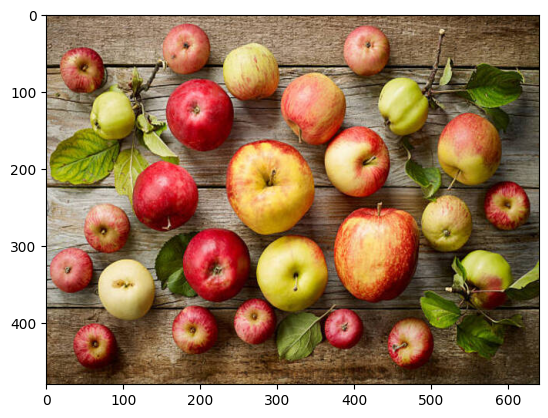

In [50]:
import torch
import torchvision.transforms as transforms
from torchvision import models
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

num_classes = 2
# GPU 사용 가능 여부 확인
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


class_names = [
    'red_apple', 'green_apple'  # 클래스에 따라 수정 필요
]

# 이미지 경로
image_path = 'apple.jpg'
# 모델 경로
model_path = 'custom_detector_640x480.pth'

# 모델 초기화 및 가중치 불러오기
model = CustomDetector(num_classes)
model.load_state_dict(torch.load(model_path, map_location=device))
model.eval()
model.to(device)

# 이미지 불러오기 및 변환
img = Image.open(image_path)
img_tensor = transforms.ToTensor()(img).to(device)
img_tensor = img_tensor.unsqueeze(0)  # 배치 차원 추가

# 추론
with torch.no_grad():
    prediction = model(img_tensor)

# 예측 결과 시각화
fig, ax = plt.subplots(1)
ax.imshow(np.array(img))



---

In [ ]:
import os
import xml.etree.ElementTree as ET
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import matplotlib.patches as patches

class myDataSet(torch.utils.data.Dataset):
    def __init__(self, image_dir, anno_dir, transform=None):
        self.image_dir = image_dir
        self.anno_dir = anno_dir
        self.transform = transform
        self.annotations = self.load_annotations()

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, idx):
        img_path, targets = self.annotations[idx]
        image = Image.open(img_path).convert("RGB")
        
        if self.transform:
            image = self.transform(image)
        
        return image, targets

    def load_annotations(self):
        annotations = []
        for xml_file in os.listdir(self.anno_dir):
            if xml_file.endswith(".xml"):
                img_filename = xml_file.replace(".xml", ".jpg")  # 이미지 파일명 생성
                img_path = os.path.join(self.image_dir, img_filename)
                anno_path = os.path.join(self.anno_dir, xml_file)
                targets = self.parse_xml(anno_path)
                annotations.append((img_path, targets))
        return annotations

    def parse_xml(self, file_path):
        tree = ET.parse(file_path)
        root = tree.getroot()

        targets = []
        for obj in root.findall("object"):
            bndbox = obj.find("bndbox")
            xmin = int(bndbox.find("xmin").text)
            ymin = int(bndbox.find("ymin").text)
            xmax = int(bndbox.find("xmax").text)
            ymax = int(bndbox.find("ymax").text)
            label = obj.find("name").text
            targets.append({
                "xmin": xmin,
                "ymin": ymin,
                "xmax": xmax,
                "ymax": ymax,
                "label": label
            })
        return targets


# 데이터셋과 데이터 로더 생성
image_dir = "images/"  # 이미지 디렉토리 경로
anno_dir = "annotations/"  # 어노테이션 XML 디렉토리 경로

# 이미지 변환 함수 정의 (ToTensor 사용)
transform = transforms.Compose([
    transforms.ToTensor(),
])

dataset = myDataSet(image_dir, anno_dir, transform=transform)
data_loader = DataLoader(dataset, batch_size=1, shuffle=True)

# 데이터셋 순회하며 이미지와 annotation 출력
for batch_idx, (images, targets) in enumerate(data_loader):
    image = images[0]  # 배치 크기가 1이므로 첫 번째 이미지 선택
    image = image.permute(1, 2, 0).numpy()  # (C, H, W) -> (H, W, C) 및 numpy 배열로 변환
    targets = targets[0]  # 첫 번째 이미지의 annotation 정보 선택
    
    # 이미지 플로팅
    plt.figure(figsize=(8, 6))
    plt.imshow(image)
    ax = plt.gca()
    count = 0
    # 각 annotation의 bounding box 그리기

    for key, value in targets.items():
        match key:
            case 'xmin':
                xmin = int(value)
            case 'ymin':
                ymin = int(value)
            case 'xmax':
                xmax = int(value)
            case 'ymax':
                ymax = int(value)
            case 'label':
                label = str(value)
        if count % 5 == 4:
            rect = patches.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, 
                                     linewidth=2, edgecolor='r', facecolor='none')
            ax.add_patch(rect)
            ax.text(xmin, ymin, label, color='r', fontsize=12, ha='left', va='top')
        count += 1
    plt.axis('off')
    plt.show()
    break
